## Unsupervised and Reinforcement Learning in neural networks, CS-434
Volodin Sergei

In [1]:
#!pip install numpy matplotlib scipy tqdm
import numpy as np
import matplotlib.pylab as plb
import scipy.io.matlab
from tqdm import tqdm

In [2]:
def som_step(centers, data, neighbor, eta, sigma):
    """Performs one step of the sequential learning for a 
    self-organized map (SOM).
    
      centers = som_step(centers,data,neighbor,eta,sigma)
    
      Input and output arguments: 
       centers  (matrix) cluster centres. Have to be in format:
                         center X dimension
       data     (vector) the actually presented datapoint to be presented in
                         this timestep
       neighbor (matrix) the coordinates of the centers in the desired
                         neighborhood.
       eta      (scalar) a learning rate
       sigma    (scalar) the width of the gaussian neighborhood function.
                         Effectively describing the width of the neighborhood
    """
    
    size_k = int(np.sqrt(len(centers)))
    
    #find the best matching unit via the minimal distance to the datapoint
    b = np.argmin(np.sum((centers - np.resize(data, (size_k ** 2, data.size))) ** 2, 1))

    # find coordinates of the winner
    a, b = np.nonzero(neighbor == b)
        
    # update all units
    for j in range(size_k**2):
        # find coordinates of this unit
        a1, b1 = np.nonzero(neighbor == j)
        # calculate the distance and discounting factor
        disc = gauss(np.sqrt((a - a1) ** 2 + (b - b1) ** 2), [0, sigma])
        # update weights        
        centers[j, :] += disc * eta * (data - centers[j, :])

In [3]:
def gauss(x, p):
    """Return the gauss function N(x), with mean p[0] and std p[1].
    Normalized such that N(x=p[0]) = 1.
    """
    return np.exp((-(x - p[0]) ** 2) / (2 * p[1] ** 2))

In [4]:
def name2digits(name):
    """ takes a string NAME and converts it into a pseudo-random selection of 4
     digits from 0-9.
     
     Example:
     name2digits('Felipe Gerhard')
     returns: [0 4 5 7]
     """
    
    name = name.lower()
    
    if len(name) > 25:
        name = name[0:25]
        
    primenumbers = [2,3,5,7,11,13,17,19,23,29,31,37,41,43,47,53,59,61,67,71,73,79,83,89,97]
    
    n = len(name)
    
    s = 0.0
    
    for i in range(n):
        s += primenumbers[i] * ord(name[i]) * 2.0 ** (i + 1)

    Data = scipy.io.matlab.loadmat('hash.mat', struct_as_record = True)
    x = Data['x']
    t = np.int(np.mod(s, x.shape[0]))

    return np.sort(x[t, :])

In [5]:
# Side of one image in pixels
side = 28

# Number of pixels in one image
dim = side ** 2

# Range of pixel intensity values
data_range = 255.0

In [6]:
# load in data and labels        
data = np.loadtxt('data.txt')
labels = np.loadtxt('labels.txt')

In [7]:
# select 4 digits        
name = 'Sergei Volodin' # REPLACE BY YOUR OWN NAME
targetdigits = name2digits(name) # assign the four digits that should be used
print(targetdigits) # output the digits that were selected
# this selects all data vectors that corresponds to one of the four digits
my_digits_subset = np.logical_or.reduce([labels == x for x in targetdigits])
labels = labels[my_digits_subset]
data = data[my_digits_subset, :]
assert(set(targetdigits) == set(np.unique(labels)))

dy, dx = data.shape

[1 3 4 6]


In [30]:
#set the size of the Kohonen map. In this case it will be 6 X 6 
size_k = 6 

#set the width of the neighborhood via the width of the gaussian that
#describes it
sigma = 2.0 

In [44]:
#initialise the centers randomly
centers = np.random.rand(size_k ** 2, dim) * data_range

#build a neighborhood matrix
neighbor = np.arange(size_k ** 2).reshape((size_k, size_k))

In [45]:
#set the learning rate
eta = 0.01

#set the maximal iteration count
tmax = 5000

In [46]:
def cluster(image):
    return np.argmin(np.linalg.norm(image - centers, axis = 1))

 10%|▉         | 499/5000 [00:09<00:54, 82.71it/s, error=1.73e+03]

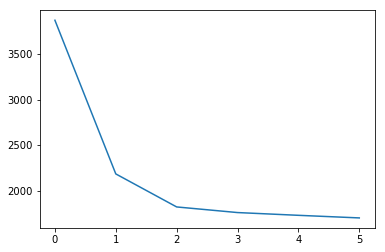

 20%|█▉        | 999/5000 [00:18<00:53, 75.21it/s, error=1.64e+03]

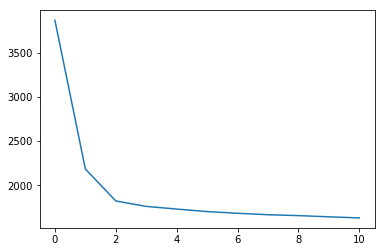

 30%|██▉       | 1499/5000 [00:28<01:10, 49.67it/s, error=1.6e+03] 

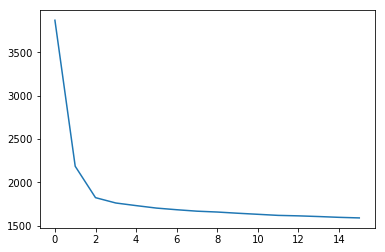

 40%|███▉      | 1999/5000 [00:38<00:40, 74.16it/s, error=1.56e+03]

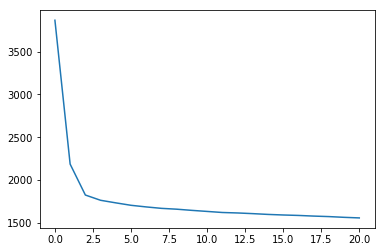

 50%|████▉     | 2499/5000 [00:47<00:32, 77.92it/s, error=1.54e+03]

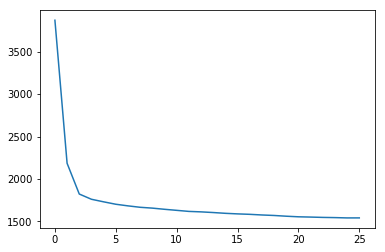

 60%|█████▉    | 2999/5000 [00:55<00:25, 79.40it/s, error=1.53e+03]

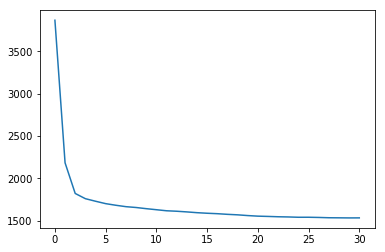

 70%|██████▉   | 3499/5000 [01:05<00:17, 86.57it/s, error=1.53e+03]

In [ ]:
#set the random order in which the datapoints should be presented
i_random = np.arange(tmax) % dy
np.random.shuffle(i_random)

error = 0
error_log = []

for batch in range(10):
    with tqdm(total = len(i_random)) as pbar:
        for t, i in enumerate(i_random):
            som_step(centers, data[i, :], neighbor, eta, sigma)
            if t % 100 == 0:
                clusters = [cluster(d) for d in data]
                errors = [np.linalg.norm(centers[clusters[i]] - data[i]) for i in range(len(data))]
                error = np.mean(errors)
                error_log.append(error)
            if t % 500 == 0 and t > 0:
                plb.plot(error_log)
                plb.show()
            pbar.set_postfix(error = error)
            pbar.update()

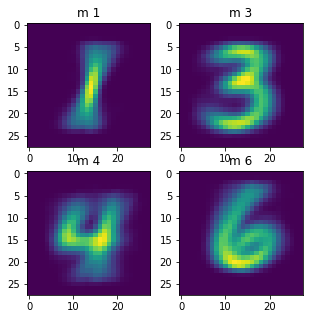

In [35]:
# Mean by label
mean_data = {label: np.mean(data[labels == label], axis = 0) for label in targetdigits}
plb.figure(figsize=(5, 5))
for i, d in enumerate(targetdigits):
    plb.subplot(2, 2, i + 1)
    plb.title('m ' + str(d))
    plb.imshow(mean_data[d].reshape([side, side]))
    
plb.show()

In [36]:
# classify an image
def classify(image):
    idx = np.argmin(np.linalg.norm([image - mean_data[label] for label in targetdigits], axis = 1))
    return targetdigits[idx]

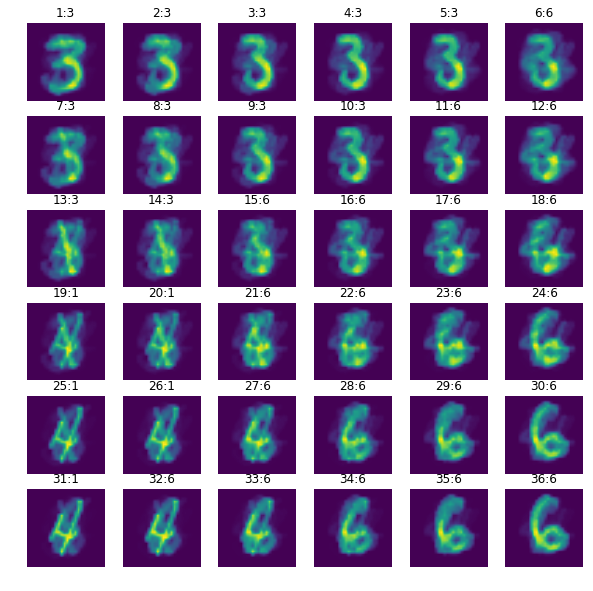

In [37]:
# for visualization, you can use this:
plb.figure(figsize=(10, 10))
for i in range(1, size_k ** 2 + 1):
    plb.subplot(size_k, size_k, i)
    plb.title('{}:{}'.format(i, classify(centers[i - 1])))
    plb.imshow(np.reshape(centers[i - 1,:], [side, side]), interpolation='bilinear')
    plb.axis('off')
        
# leave the window open at the end of the loop
plb.show()
plb.draw()